In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:
import pandas as pd
import numpy as np
import warnings
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import ast
from nltk.tokenize import word_tokenize
import json
import random
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

warnings.filterwarnings("ignore")


train_data = pd.read_csv("train_data.csv")
train_data["target_labels_positions_conv"] = train_data["target_labels_positions"].apply(
    lambda x: ast.literal_eval(x)
)

In [2]:
def preprocess_fred(text, label_dict):
    if len(label_dict) > 0:
        label = "Да, содержит"
        fin_list = []
        if "B-value" in label_dict:
            for i in label_dict["B-value"]:
                count = i
                item_list = []
                item_list.append(i)
                if "I-value" in label_dict:
                    for j in label_dict["I-value"]:
                        if j - 1 == count:
                            item_list.append(j)
                            count = j
                    fin_list.append(item_list)

        words = []
        tokens = word_tokenize(text)
        if len(fin_list) > 0:
            for list in fin_list:
                words_list = []
                for item in list:
                    word_item = tokens[item]
                    words_list.append(word_item)
                words_list_reworked = " ".join(words_list)
                words.append(words_list_reworked)

        discount_list = []
        if "B-discount" in label_dict:
            for i in label_dict["B-discount"]:
                word_discount = tokens[i]
                discount_list.append(word_discount)
        labels_reworked = {'label':label, 'value_words': words, 'discount_words': discount_list}
    else:
        label = "Нет, не содержит"
        labels_reworked = {"label": label, "value_words": [], "discount_words": []}
        
    return labels_reworked

In [3]:
train_data["labels_reworked"] = train_data[
    ["processed_text", "target_labels_positions_conv"]
].apply(
    lambda train_data: preprocess_fred(
        train_data["processed_text"], train_data["target_labels_positions_conv"]
    ),
    axis=1,
)
train_data

,processed_text,target_labels_positions,target_labels_positions_conv,labels_reworked
0,аа союзная тридцать пять дробь один лариса сое...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
1,аа приложение мне показывает к оплате у меня п...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
2,да лисное по призрак лишнее ну почему иду пять...,"{'I-value': [140], 'B-value': [139], 'B-discou...","{'I-value': [140], 'B-value': [139], 'B-discou...","{'label': 'Да, содержит', 'value_words': ['два..."
3,а что добрый день NAME у меня пришел какой то ...,{'B-discount': [12]},{'B-discount': [12]},"{'label': 'Да, содержит', 'value_words': [], '..."
4,у меня западный с утра да да еще да да самый в...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
...,...,...,...,...
3394,а доброе утро меня заинтересовала ваш проект н...,"{'I-value': [224, 225], 'B-value': [223], 'B-d...","{'I-value': [224, 225], 'B-value': [223], 'B-d...","{'label': 'Да, содержит', 'value_words': ['до ..."
3395,здравствуйте меня зовут иван я бы хотел сегодн...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
3396,целенаправлен на голосовой почтовый ящик вы мо...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
3397,NAME зовут NAME я хотела уточнить ээ своего ме...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."


In [6]:
dataset = Dataset.from_pandas(train_data)
dataset

Dataset({
    features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked'],
    num_rows: 3399
})

In [4]:
def add_tags(example):

    tags = []
    new_dict = {}
    labels_dict = ast.literal_eval(example["target_labels_positions"])
    tags_index_list = [i[0] for i in labels_dict.values()]
    for key, value in labels_dict.items():
        for i in value:
            new_dict[i] = key
    for index, i in enumerate(word_tokenize(example["processed_text"])):
        if index in tags_index_list:
            if new_dict[index] == "B-discount":
                tags.append("B-discount")
            elif new_dict[index] == "B-value":
                tags.append("B-value")
            else:
                tags.append("I-value")
        else:
            tags.append("O")


    example["ner_tag"] = tags

    return example

In [7]:
added_tags_data = dataset.map(add_tags)
added_tags_data

Map:   0%|          | 0/3399 [00:00<?, ? examples/s]

Dataset({
    features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag'],
    num_rows: 3399
})

In [13]:
added_tags_data = added_tags_data.shuffle()
train_test_split = added_tags_data.train_test_split(test_size=0.1)

In [14]:
def createCLASS_dataset(sample, prompts_file_path):
    """function to create classification dataset"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["CLASS"][str(num)]

    sample["aspect_ner_output"] = f"Ответ: \n{sample['labels_reworked']['label']}</s>"
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Классификация текста \n{instruction}\n{sample['processed_text']}\n"
    )
    return sample

In [15]:
CLASS_dataset = train_test_split["train"].map(
    createCLASS_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
CLASS_dataset[0]

Map:   0%|          | 0/3059 [00:00<?, ? examples/s]

{'processed_text': 'NAME здравствуйте меня зовут NAME вы не могли бы меня сориентировать я звоню по жк у символа хотела бы у да я бы хотела бы уточнить вообще цена категорию на студии я смотрю у меня приложение какой то самолет плюс там одни цены а захожу через браузер там другие цены стоимость то есть ассосия заключащие личности новострой мне уже одобренно угу это в двадцать пятом году сдача будет правильно ага все хорошо ладно спасибо вам большое ну вы знаете мы обсудим тогда дома еще если что мы тогда свяжимся хорошоздравствуйте уроков не закрывать а вас пересилива старые дайте самолет точка ру сайт расстройщиком сроки заселения по данному комплексу представлен двадцать третий и двадцать пятый год такого расчетти не услышала NAME самый комплекс находится территория ADDRESS метро ADDRESS ближайший деликатная станция те же дрожащая лично польз партнер на территории комплекса плоскостной наземный с внешней стороны ADDRESS три очередь у нас уже заселены проживают на территории детские с

In [16]:
def createDISC_dataset(sample, prompts_file_path):
    """function to create DISCOUNT_SEARCH"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["DISC"][str(num)]
    sample["discount_list"] = ",".join([item for item in sample["labels_reworked"]['discount_words']])

    sample["aspect_ner_output"] = f"Ответ: \n{sample['discount_list']}</s>"
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Поиск упоминания скидки \n{instruction}\nТекст: \n{sample['processed_text']}\n"
    )
    return sample

In [17]:
DISC_dataset = train_test_split["train"].map(
    createDISC_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
DISC_dataset[0]

Map:   0%|          | 0/3059 [00:00<?, ? examples/s]

{'processed_text': 'NAME здравствуйте меня зовут NAME вы не могли бы меня сориентировать я звоню по жк у символа хотела бы у да я бы хотела бы уточнить вообще цена категорию на студии я смотрю у меня приложение какой то самолет плюс там одни цены а захожу через браузер там другие цены стоимость то есть ассосия заключащие личности новострой мне уже одобренно угу это в двадцать пятом году сдача будет правильно ага все хорошо ладно спасибо вам большое ну вы знаете мы обсудим тогда дома еще если что мы тогда свяжимся хорошоздравствуйте уроков не закрывать а вас пересилива старые дайте самолет точка ру сайт расстройщиком сроки заселения по данному комплексу представлен двадцать третий и двадцать пятый год такого расчетти не услышала NAME самый комплекс находится территория ADDRESS метро ADDRESS ближайший деликатная станция те же дрожащая лично польз партнер на территории комплекса плоскостной наземный с внешней стороны ADDRESS три очередь у нас уже заселены проживают на территории детские с

In [18]:
def createVAL_dataset(sample, prompts_file_path):
    """function to create VALUE_SEARCH"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["VAL"][str(num)]

    sample["discount_list"] = ",".join(
        [item for item in sample["labels_reworked"]["discount_words"]]
    )
    sample["value_list"] = ",".join(
        [item for item in sample["labels_reworked"]["value_words"]]
    )

    sample["aspect_ner_output"] = f"Ответ: \n{sample['value_list']}</s>"
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Поиск размера скидки \n{instruction}\nТекст: \n{sample['processed_text']}\nУпомянутые в тексте скидки:{sample['discount_list']}"
    )
    return sample

In [19]:
VAL_dataset = train_test_split["train"].map(
    createVAL_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
VAL_dataset[300]

Map:   0%|          | 0/3059 [00:00<?, ? examples/s]

{'processed_text': 'здравствуйте я звоню по квартире в райте кашириных сто шестьдесят четыре а продаете да братик поширнос пошли NAME два инициировано то есть вот вот из этого сложилась наша вот такая ставка оно как бы в рекламе тоже получил там десять процентов но в итоге получается не знаю есть могу тратить время на другие банки или нет хорошо завтра хорошо аажите пожалуйста аа раз услыня квартиры еще есть на полинке квартиры однокомнатная приват не по три ну мы не хотели маленькую да хотели чтобы была вот такая побольше и чтобы вот это махеева королева восемь девятьсот девятнадцать триста сорок восемь десять шестьдесят семь алло здравствуйте скажите пожалуйста вот брать кошельная сто шестьдесят четыре еще продается да там студия я хотела уточнить она как студия или нет или кухня а можно ли посмотреть сегодня в шесть ну в шесть минут пять там и семь скажите там люди проживает понятно угу а скажите да у нас уже одобренная ипотеку и наказ а в сбербанке там двенадцать с чем то двенадцат

In [20]:
def createVAL_FIN_dataset(sample, prompts_file_path):
    """function to create DISCOUNT and VALUE SEARCH"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["ALL"][str(num)]

    sample["discount_list"] = ",".join(
        [item for item in sample["labels_reworked"]["discount_words"]]
    )
    sample["value_list"] = ",".join(
        [item for item in sample["labels_reworked"]["value_words"]]
    )

    sample["aspect_ner_output"] = (
        f"Ответ: \n{sample['discount_list']}:{sample['value_list']}</s>"
    )
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Поиск упоминания скидки и ее размера\n{instruction}\nТекст: \n{sample['processed_text']}\n"
    )
    return sample

In [21]:
VAL_FINdataset = train_test_split["train"].map(
    createVAL_FIN_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
VAL_FINdataset[300]

Map:   0%|          | 0/3059 [00:00<?, ? examples/s]

{'processed_text': 'здравствуйте я звоню по квартире в райте кашириных сто шестьдесят четыре а продаете да братик поширнос пошли NAME два инициировано то есть вот вот из этого сложилась наша вот такая ставка оно как бы в рекламе тоже получил там десять процентов но в итоге получается не знаю есть могу тратить время на другие банки или нет хорошо завтра хорошо аажите пожалуйста аа раз услыня квартиры еще есть на полинке квартиры однокомнатная приват не по три ну мы не хотели маленькую да хотели чтобы была вот такая побольше и чтобы вот это махеева королева восемь девятьсот девятнадцать триста сорок восемь десять шестьдесят семь алло здравствуйте скажите пожалуйста вот брать кошельная сто шестьдесят четыре еще продается да там студия я хотела уточнить она как студия или нет или кухня а можно ли посмотреть сегодня в шесть ну в шесть минут пять там и семь скажите там люди проживает понятно угу а скажите да у нас уже одобренная ипотеку и наказ а в сбербанке там двенадцать с чем то двенадцат

In [22]:
FIN_test = train_test_split["test"].map(
    createVAL_FIN_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

In [23]:
from datasets import concatenate_datasets

combined_datasets = concatenate_datasets(
    [CLASS_dataset, DISC_dataset, VAL_dataset, VAL_FINdataset],
)
combined_datasets = combined_datasets.shuffle()
dataset_train_test = combined_datasets.train_test_split(test_size=0.1)
final_ds = DatasetDict(
    {
        "train": dataset_train_test["train"],
        "test": dataset_train_test["test"],
        "val": FIN_test,
    }
)

In [24]:
final_ds

DatasetDict({
    train: Dataset({
        features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag', 'aspect_ner_output', 'aspect_ner_input', 'discount_list', 'value_list'],
        num_rows: 11012
    })
    test: Dataset({
        features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag', 'aspect_ner_output', 'aspect_ner_input', 'discount_list', 'value_list'],
        num_rows: 1224
    })
    val: Dataset({
        features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag', 'discount_list', 'value_list', 'aspect_ner_output', 'aspect_ner_input'],
        num_rows: 340
    })
})

In [25]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")
tokenized_inputs = concatenate_datasets(
    [
        final_ds["train"],
        final_ds["test"],
        final_ds["val"],
    ],
).map(
    lambda x: tokenizer(x["aspect_ner_input"], truncation=True),
    batched=True,
    remove_columns=[
        "processed_text",
        "target_labels_positions",
        "target_labels_positions_conv",
        "labels_reworked",
        "ner_tag",
        "discount_list",
        "value_list",
        "aspect_ner_output",
        "aspect_ner_input",
    ],
)
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/12576 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [26]:
tokenized_targets = concatenate_datasets(
    [
        final_ds["train"],
        final_ds["test"],
        final_ds["val"],
    ],
).map(
    lambda x: tokenizer(x["aspect_ner_output"], truncation=True),
    batched=True,
    remove_columns=[
        "processed_text",
        "target_labels_positions",
        "target_labels_positions_conv",
        "labels_reworked",
        "ner_tag",
        "discount_list",
        "value_list",
        "aspect_ner_output",
        "aspect_ner_input",
    ],
)
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])

Map:   0%|          | 0/12576 [00:00<?, ? examples/s]

In [27]:
def tokenize_function(
    sample, tokenizer, max_source_length, max_target_length, padding="max_length"
):
    """function to tokenize data for FLAN"""
    model_inputs = tokenizer(
        sample["aspect_ner_input"],
        max_length=max_source_length,
        padding=padding,
        truncation=True,
    )
    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(
        text_target=sample["aspect_ner_output"],
        max_length=max_target_length,
        padding=padding,
        truncation=True,
    )
    # If we are padding here, replace all tokenizer.pad_token_id in the labels
    # by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label]
            for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [28]:
tokenized_dataset = final_ds.map(
    tokenize_function,
    batched=True,
    fn_kwargs={
        "max_source_length": max_source_length,
        "max_target_length": max_target_length,
        "tokenizer": tokenizer,
    },
    remove_columns=[
        "processed_text",
        "target_labels_positions",
        "target_labels_positions_conv",
        "labels_reworked",
        "ner_tag",
        "discount_list",
        "value_list",
        "aspect_ner_output",
        "aspect_ner_input",
    ],
)

Map:   0%|          | 0/11012 [00:00<?, ? examples/s]

Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

In [30]:
model = AutoModelForSeq2SeqLM.from_pretrained("./fred_samolet")

In [25]:
model = AutoModelForSeq2SeqLM.from_pretrained("ai-forever/FRED-T5-large")
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8,
)

In [26]:
repository_id = f"fred-test"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False,  # Overflows with fp16
    learning_rate=1e-4,
    num_train_epochs=5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    optim="adamw_torch",
    # logging & evaluation strategies
    evaluation_strategy="epoch",
    save_strategy="no",
    save_total_limit=1,
    push_to_hub=False,
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)
trainer.train()

 12%|█▏        | 500/4131 [11:40<1:24:45,  1.40s/it]

{'loss': 0.7223, 'grad_norm': 0.8490161895751953, 'learning_rate': 9.768630616088244e-05, 'epoch': 0.36}


 24%|██▍       | 1000/4131 [23:21<1:13:05,  1.40s/it]

{'loss': 0.0885, 'grad_norm': 0.8747517466545105, 'learning_rate': 8.423459779391983e-05, 'epoch': 0.73}


 99%|█████████▉| 152/153 [01:09<00:00,  2.18it/s]
                                                   A
100%|██████████| 153/153 [01:09<00:00,  2.19it/s]
                                                 

{'eval_loss': 0.06259568780660629, 'eval_runtime': 70.1092, 'eval_samples_per_second': 17.458, 'eval_steps_per_second': 2.182, 'epoch': 1.0}


 36%|███▋      | 1500/4131 [36:11<1:01:26,  1.40s/it] 

{'loss': 0.068, 'grad_norm': 1.761650562286377, 'learning_rate': 7.078288942695722e-05, 'epoch': 1.09}


 48%|████▊     | 2000/4131 [47:52<49:45,  1.40s/it]  

{'loss': 0.0567, 'grad_norm': 1.4479180574417114, 'learning_rate': 5.733118105999462e-05, 'epoch': 1.45}


 61%|██████    | 2500/4131 [59:33<38:06,  1.40s/it]

{'loss': 0.048, 'grad_norm': 0.08828524500131607, 'learning_rate': 4.387947269303202e-05, 'epoch': 1.82}


 99%|█████████▉| 152/153 [01:09<00:00,  2.18it/s]
                                                     
100%|██████████| 153/153 [01:09<00:00,  2.19it/s]
                                                 

{'eval_loss': 0.049567677080631256, 'eval_runtime': 70.1218, 'eval_samples_per_second': 17.455, 'eval_steps_per_second': 2.182, 'epoch': 2.0}


 73%|███████▎  | 3000/4131 [1:12:23<26:24,  1.40s/it]  

{'loss': 0.0479, 'grad_norm': 0.5144916772842407, 'learning_rate': 3.0427764326069414e-05, 'epoch': 2.18}


 85%|████████▍ | 3500/4131 [1:24:04<14:44,  1.40s/it]

{'loss': 0.0393, 'grad_norm': 0.4854886531829834, 'learning_rate': 1.6976055959106806e-05, 'epoch': 2.54}


 97%|█████████▋| 4000/4131 [1:35:45<03:03,  1.40s/it]

{'loss': 0.0367, 'grad_norm': 0.1827506273984909, 'learning_rate': 3.5243475921442024e-06, 'epoch': 2.9}


 99%|█████████▉| 152/153 [01:09<00:00,  2.18it/s]
                                                     
100%|██████████| 4131/4131 [1:39:58<00:00,  1.45s/it]

{'eval_loss': 0.046784643083810806, 'eval_runtime': 70.1167, 'eval_samples_per_second': 17.457, 'eval_steps_per_second': 2.182, 'epoch': 3.0}
{'train_runtime': 5998.4332, 'train_samples_per_second': 5.507, 'train_steps_per_second': 0.689, 'train_loss': 0.1352017902918169, 'epoch': 3.0}


TrainOutput(global_step=4131, training_loss=0.1352017902918169, metrics={'train_runtime': 5998.4332, 'train_samples_per_second': 5.507, 'train_steps_per_second': 0.689, 'total_flos': 1.0364081947213824e+17, 'train_loss': 0.1352017902918169, 'epoch': 3.0})

In [51]:
def convert_prediction_to_tags(text, prediction):
    tokens = word_tokenize(text)
    if ":" in prediction:
        discounts_predicted = prediction.split(':')[0]
        values_predicted = prediction.split(':')[1]
    else:
        discounts_predicted = ''
        values_predicted = ''
    list = [i for i in values_predicted.split(',')]
    b_values = []
    i_values = []
    for item in list:
        item_list = item.split(' ')
        if len(item_list) > 0:
            for j, _ in enumerate(tokens):
                if tokens[j:len(item_list)+j] == item_list:
                    b_values.append(j)
                    end = len(item_list) + j
                    for k in range(end-j):
                        i_values.append(end)
                        end -= 1
                        if end != j:
                            continue
    tags = []
    for word in tokens:
        if word in discounts_predicted.split(','):
            tags.append('B-discount')
        elif tokens.index(word) in b_values:
            tags.append('B-value')
        elif tokens.index(word) in i_values:
            tags.append('I-value')
        else:
            tags.append('O')  

    return tags                     

In [34]:
import torch
device = torch.device("cpu")


def generate_response(
    model, tokenizer, question, top_p, temperature, prompts_path, device
):
    """function to generate response from FLAN models"""
    with open(prompts_path, encoding="UTF-8") as fp:
        template = json.load(fp)
    num = random.randint(1, len(template))
    instruction = template["ALL"][str(num)]
    input = f"<LM>Задача: Поиск упоминания скидки и ее размера\n{instruction}\n{question}\n"
    input_ids = tokenizer.encode(input, return_tensors="pt")
    sample_output = model.generate(
        input_ids=input_ids.to(device),
        do_sample=True,
        max_length=100,
        top_p=top_p,
        temperature=temperature,
        top_k=70,
        early_stopping=True,
        # no_repeat_ngram_size=2,
        eos_token_id=tokenizer.eos_token_id,
    )
    out = tokenizer.decode(sample_output[0][1:], skip_special_tokens=True)
    if "</s>" in out:
        out = out[: out.find("</s>")].strip()

    out = out.split("Ответ:")[1].strip().replace(": ", ":").replace('_', '')
    return out

In [52]:
from tqdm import tqdm
predictions = []
for item in tqdm(final_ds['val']):
    answer = generate_response(
        model=model,
        tokenizer=tokenizer,
        question=item["processed_text"],
        top_p=0.6,
        temperature=0.7,
        prompts_path='prompts_joint_samolet.json',
        device=device,
    )
    tag_list = convert_prediction_to_tags(item["processed_text"], answer)
    new_line = {"processed_text": item["processed_text"], 'label':tag_list}
    predictions.append(new_line)

100%|██████████| 340/340 [05:45<00:00,  1.02s/it]


In [53]:
y_true_list = [i for i in final_ds["val"]["ner_tag"]]
len(y_true_list)

340

In [54]:
true_flat = []
for item in y_true_list:
    true_flat.extend(item)
len(true_flat)


80636

In [55]:
pred_falt = []
for item in predictions:
    pred_falt.extend(item['label'])
len(pred_falt)

80636

In [56]:
weights = {'B-discount':1, 'B-value':2, 'I-value':2, 'O':0.003}

In [58]:
from sklearn.metrics import precision_recall_fscore_support

def weighted_f1(y_true, y_pred, weights):
    """Расчет взвешенной F1 меры с индивидуальными весами для классов."""

    # рассчитываем F1 для всех классов
    _, _, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=list(weights.keys())
    )

    # вычисление взвешенной F-меры
    weighted_f1 = np.sum(
        f1
        * [weights[label] for label in np.unique(y_true + y_pred)]
        * support
    ) / np.sum(
        support * [weights[label] for label in np.unique(y_true + y_pred)]
    )
    return weighted_f1

weighted_f1_score = weighted_f1(true_flat, pred_falt, weights)
print(weighted_f1_score)

0.7392844401299952


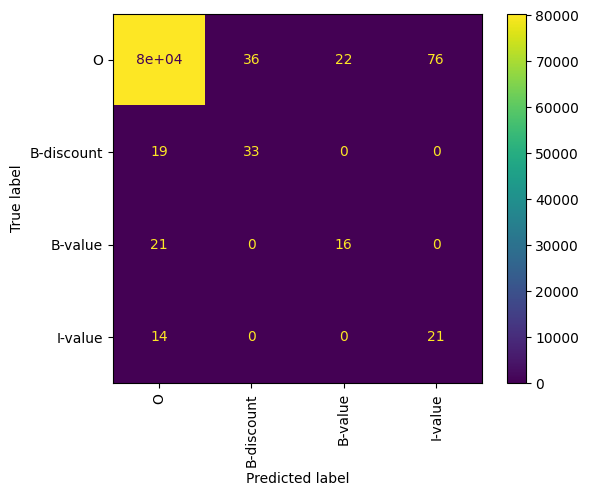

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
label_list = ["O", "B-discount", "B-value", "I-value"]

cm = confusion_matrix(true_flat, pred_falt, labels=label_list)
cm_display = ConfusionMatrixDisplay(cm, display_labels=label_list)
cm_display.plot(xticks_rotation="vertical")
plt.show()

In [ ]:
model.save_pretrained("./results/samolet_fred")
tokenizer.save_pretrained("./results/samolet_fred")

In [61]:
from sklearn.metrics import classification_report

print(
    classification_report(true_flat, pred_falt, labels=label_list,
    )
)

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     80512
  B-discount       0.48      0.63      0.55        52
     B-value       0.42      0.43      0.43        37
     I-value       0.22      0.60      0.32        35

    accuracy                           1.00     80636
   macro avg       0.53      0.67      0.57     80636
weighted avg       1.00      1.00      1.00     80636

